# Protein Ligand Complex MD Setup tutorial using BioExcel Building Blocks (biobb)
### Based on the official Gromacs tutorial: http://www.mdtutorials.com/gmx/complex/index.html
***
This tutorial aims to illustrate the process of **setting up a simulation system** containing a **protein in complex with a ligand**, step by step, using the **BioExcel Building Blocks library (biobb)**. The particular example used is the **T4 lysozyme** L99A/M102Q protein (PDB code 3HTB, [https://doi.org/10.2210/pdb3HTB/pdb](https://doi.org/10.2210/pdb3HTB/pdb)), in complex with the **2-propylphenol** small molecule (3-letter Code JZ4, [https://www.rcsb.org/ligand/JZ4](https://www.rcsb.org/ligand/JZ4)). 
***
**Biobb modules** used:

 - [biobb_io](https://github.com/bioexcel/biobb_io): Tools to fetch biomolecular data from public databases.
 - [biobb_model](https://github.com/bioexcel/biobb_model): Tools to model macromolecular structures.
 - [biobb_chemistry](https://github.com/bioexcel/biobb_chemistry): Tools to manipulate chemical data.
 - [biobb_gromacs](https://github.com/bioexcel/biobb_gromacs): Tools to setup and run Molecular Dynamics simulations.
 - [biobb_analysis](https://github.com/bioexcel/biobb_analysis): Tools to analyse Molecular Dynamics trajectories.
 - [biobb_structure_utils](https://github.com/bioexcel/biobb_structure_utils):  Tools to modify or extract information from a PDB structure file.
 
### Auxiliary libraries used

* [jupyter](https://jupyter.org/): Free software, open standards, and web services for interactive computing across all programming languages.
* [nglview](http://nglviewer.org/#nglview): Jupyter/IPython widget to interactively view molecular structures and trajectories in notebooks.
* [plotly](https://plot.ly/python/offline/): Python interactive graphing library integrated in Jupyter notebooks.
* [simpletraj](https://github.com/arose/simpletraj): Lightweight coordinate-only trajectory reader based on code from GROMACS, MDAnalysis and VMD.

### Conda Installation and Launch

```console
git clone https://github.com/bioexcel/biobb_wf_protein-complex_md_setup.git
cd biobb_wf_protein-complex_md_setup
conda env create -f conda_env/environment.yml
conda activate biobb_wf_protein-complex_md_setup
jupyter-notebook biobb_wf_protein-complex_md_setup/notebooks/biobb_wf_protein-complex_md_setup.ipynb
```

***
### Pipeline steps:
 1. [Input Parameters](#input)
 2. [Fetching PDB Structure](#fetch)
 3. [Fix Protein Structure](#fix)
 4. [Create Protein System Topology](#top)
 5. [Create ligand system topology](#ligtop)
 6. [Preparing Ligand Restraints](#restraints)
 7. [Create new protein-ligand complex structure file](#complex)
 8. [Create new protein-ligand complex topology file](#complextop)
 9. [Create Solvent Box](#box)
 10. [Fill the Box with Water Molecules](#water)
 11. [Adding Ions](#ions)
 12. [Energetically Minimize the System](#min)
 13. [Equilibrate the System (NVT)](#nvt)
 14. [Equilibrate the System (NPT)](#npt)
 15. [Free Molecular Dynamics Simulation](#free)
 16. [Post-processing and Visualizing Resulting 3D Trajectory](#post)
 17. [Output Files](#output)
 18. [Questions & Comments](#questions)
 
***
***
<img src="https://bioexcel.eu/wp-content/uploads/2019/04/Bioexcell_logo_1080px_transp.png" alt="Bioexcel2 logo"
	title="Bioexcel2 logo" width="400" />
***


## Initializing colab
The three cells below are used only in case this notebook is executed via **Google Colab**. Take into account that, for running conda on **Google Colab**, the **condacolab** library must be installed. As [explained here](https://pypi.org/project/condacolab/), the installation requires a **kernel restart**, so when running this notebook in **Google Colab**, don't run all cells until this **installation** is properly **finished** and the **kernel** has **restarted**.

In [1]:
# Only executed when using google colab
import sys
if 'google.colab' in sys.modules:
  !git clone https://github.com/bioexcel/biobb_wf_protein-complex_md_setup.git
  !pip install -q condacolab
  import condacolab
  condacolab.install()

In [2]:
if 'google.colab' in sys.modules: 
  # Install conda environment
  !mamba env update -n base -f biobb_wf_protein-complex_md_setup/conda_env/environment.yml
  # Install specific biopython version due to compatibility issues
  !pip install "biopython<1.80"
  # Fix Python path to prioritize conda packages
  conda_path = '/usr/local'
  sys.path.insert(0, f'{conda_path}/lib/python3.11/site-packages')
  # Enable widgets for colab
  from google.colab import output 
  output.enable_custom_widget_manager() 
  # Change working dir
  import os 
  os.chdir("biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks") 
  print(f"New working directory: {os.getcwd()}")

In [3]:
# Store original Colab paths
ORIGINAL_PATHS = [p for p in sys.path if '/usr/local/lib/python3.12' in p or 'dist-packages' in p]
CONDA_PATHS = [p for p in sys.path if '/usr/local/lib/python3.11' in p]

def use_colab_plotly():
    """Switch to Colab's original plotly"""
    # Move Colab paths to the front
    for path in reversed(ORIGINAL_PATHS):
        if path in sys.path:
            sys.path.remove(path)
        sys.path.insert(0, path)
    
    # Reload plotly and nbformat from Colab's environment
    if 'plotly' in sys.modules:
        del sys.modules['plotly']
        del sys.modules['plotly.graph_objs']
        # Delete all plotly submodules
        to_delete = [m for m in sys.modules if m.startswith('plotly')]
        for m in to_delete:
            del sys.modules[m]
    if 'nbformat' in sys.modules:
        del sys.modules['nbformat']

def use_conda_env():
    """Switch back to conda environment"""
    # Move conda paths to the front
    for path in reversed(CONDA_PATHS):
        if path in sys.path:
            sys.path.remove(path)
        sys.path.insert(0, path)
    
    # Clean up Colab's plotly/nbformat so conda versions load next time
    if 'plotly' in sys.modules:
        to_delete = [m for m in sys.modules if m.startswith('plotly')]
        for m in to_delete:
            del sys.modules[m]
    if 'nbformat' in sys.modules:
        del sys.modules['nbformat']

<a id="input"></a>
## Input parameters
**Input parameters** needed:
 - **pdbCode**: PDB code of the protein-ligand complex structure (e.g. 3HTB, [https://doi.org/10.2210/pdb3HTB/pdb](https://doi.org/10.2210/pdb3HTB/pdb))
 - **ligandCode**: Small molecule 3-letter code for the ligand structure (e.g. JZ4, [https://www.rcsb.org/ligand/JZ4](https://www.rcsb.org/ligand/JZ4))
 - **mol_charge**: Charge of the small molecule, needed to add hydrogen atoms.

In [4]:
import nglview
import ipywidgets
import os
import zipfile
import sys

pdbCode = "3HTB"
ligandCode = "JZ4"
mol_charge = 0

<a id="fetch"></a>
***
## Fetching PDB structure
Downloading **PDB structure** with the **protein-ligand complex** from the RCSB PDB database.<br>
Alternatively, a PDB file can be used as starting structure. <br>
Splitting the molecule in **three different files**: 
- **proteinFile**: Protein structure
- **ligandFile**: Ligand structure
- **complexFile**: Protein-ligand complex structure 

***
**Building Blocks** used:
 - [Pdb](https://biobb-io.readthedocs.io/en/latest/api.html#module-api.pdb) from **biobb_io.api.pdb**
 - [ExtractHeteroAtoms](https://biobb-structure-utils.readthedocs.io/en/latest/utils.html#module-utils.extract_heteroatoms) from **biobb_structure_utils.utils.extract_heteroatoms**
 - [ExtractMolecule](https://biobb-structure-utils.readthedocs.io/en/latest/utils.html#module-utils.extract_molecule) from **biobb_structure_utils.utils.extract_molecule**
 - [CatPDB](https://biobb-structure-utils.readthedocs.io/en/latest/utils.html#module-utils.cat_pdb) from **biobb_structure_utils.utils.cat_pdb**
***

In [5]:
# Downloading desired PDB file 
# Import module
from biobb_io.api.pdb import pdb

# Create properties dict and inputs/outputs
downloaded_pdb = pdbCode+'.orig.pdb'
prop = {
    'pdb_code': pdbCode,
    'filter': False
}

# Create and launch bb
pdb(output_pdb_path=downloaded_pdb,
    properties=prop)

2026-01-28 17:14:50,596 [MainThread  ] [INFO ]  Module: biobb_io.api.pdb Version: 5.2.0
2026-01-28 17:14:50,597 [MainThread  ] [INFO ]  Downloading 3htb from: https://www.ebi.ac.uk/pdbe/entry-files/download/pdb3htb.ent
2026-01-28 17:14:50,918 [MainThread  ] [INFO ]  Writting pdb to: 3HTB.orig.pdb
2026-01-28 17:14:50,923 [MainThread  ] [INFO ]  


0

In [6]:
# Extracting Protein, Ligand and Protein-Ligand Complex to three different files
# Import module
from biobb_structure_utils.utils.extract_heteroatoms import extract_heteroatoms
from biobb_structure_utils.utils.extract_molecule import extract_molecule
from biobb_structure_utils.utils.cat_pdb import cat_pdb

# Create properties dict and inputs/outputs
proteinFile = pdbCode+'.pdb'
ligandFile = ligandCode+'.pdb'
complexFile = pdbCode+'_'+ligandCode+'.pdb'

prop = {
     'heteroatoms' : [{"name": "JZ4"}]
}

extract_heteroatoms(input_structure_path=downloaded_pdb,
     output_heteroatom_path=ligandFile,
     properties=prop)

extract_molecule(input_structure_path=downloaded_pdb,
     output_molecule_path=proteinFile)

print(proteinFile, ligandFile, complexFile)

cat_pdb(input_structure1=proteinFile,
       input_structure2=ligandFile,
       output_structure_path=complexFile)

2026-01-28 17:14:52,127 [MainThread  ] [INFO ]  Module: biobb_structure_utils.utils.extract_heteroatoms Version: 5.2.0
2026-01-28 17:14:52,129 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_36e50589-f482-4202-a32e-c6ffb2dbcc8d
2026-01-28 17:14:52,130 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB.orig.pdb --> sandbox_36e50589-f482-4202-a32e-c6ffb2dbcc8d
2026-01-28 17:14:52,163 [MainThread  ] [INFO ]  Writting pdb to: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_36e50589-f482-4202-a32e-c6ffb2dbcc8d/JZ4.pdb
2026-01-28 17:14:52,165 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-comp

0

### Visualizing 3D structures
Visualizing the generated **PDB structures** using **NGL**:  
- **Protein structure** (Left)
- **Ligand structure** (Center)
- **Protein-ligand complex** (Right)  

In [7]:
# Show structures: protein, ligand and protein-ligand complex
view1 = nglview.show_structure_file(proteinFile)
view1._remote_call('setSize', target='Widget', args=['350px','400px'])
view1.camera='orthographic'
view1
view2 = nglview.show_structure_file(ligandFile)
view2.add_representation(repr_type='ball+stick')
view2._remote_call('setSize', target='Widget', args=['350px','400px'])
view2.camera='orthographic'
view2
view3 = nglview.show_structure_file(complexFile)
view3.add_representation(repr_type='licorice', radius='.5', selection=ligandCode)
view3._remote_call('setSize', target='Widget', args=['350px','400px'])
view3.camera='orthographic'
view3
ipywidgets.HBox([view1, view2, view3])

<a id="fix"></a>
***
## Fix protein structure
**Checking** and **fixing** (if needed) the protein structure:<br>
- **Modeling** **missing side-chain atoms**, modifying incorrect **amide assignments**, choosing **alternative locations**.<br>
- **Checking** for missing **backbone atoms**, **heteroatoms**, **modified residues** and possible **atomic clashes**.

***
**Building Blocks** used:
 - [FixSideChain](https://biobb-model.readthedocs.io/en/latest/model.html#module-model.fix_side_chain) from **biobb_model.model.fix_side_chain**
***

In [8]:
# Check & Fix Protein Structure
# Import module
from biobb_model.model.fix_side_chain import fix_side_chain

# Create prop dict and inputs/outputs
fixed_pdb = pdbCode+'_fixed.pdb'

# Create and launch bb
fix_side_chain(input_pdb_path=proteinFile,
             output_pdb_path=fixed_pdb)

2026-01-28 17:14:55,952 [MainThread  ] [INFO ]  Module: biobb_model.model.fix_side_chain Version: 5.2.0
2026-01-28 17:14:55,954 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_32336177-d725-46ea-9846-bf90f1c60784
2026-01-28 17:14:55,956 [MainThread  ] [INFO ]  Copy to stage: 3HTB.pdb --> sandbox_32336177-d725-46ea-9846-bf90f1c60784
2026-01-28 17:14:55,959 [MainThread  ] [INFO ]  Launching command (it may take a while): check_structure -i /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_32336177-d725-46ea-9846-bf90f1c60784/3HTB.pdb -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_32336177-d725-46ea-9846-bf90f1c60784/3HTB_fixed.pdb --force_save fixside --fix ALL
2026-01-28 17:14:56,323 [MainThread  

0

<a id="top"></a>
***
## Create protein system topology
**Building GROMACS topology** corresponding to the protein structure.<br>
Force field used in this tutorial is [**amber99sb-ildn**](https://dx.doi.org/10.1002%2Fprot.22711): AMBER **parm99** force field with **corrections on backbone** (sb) and **side-chain torsion potentials** (ildn). Water molecules type used in this tutorial is [**spc/e**](https://pubs.acs.org/doi/abs/10.1021/j100308a038).<br>
Adding **hydrogen atoms** if missing. Automatically identifying **disulfide bridges**. <br>

Generating two output files: 
- **GROMACS structure** (gro file)
- **GROMACS topology** ZIP compressed file containing:
    - *GROMACS topology top file* (top file)
    - *GROMACS position restraint file/s* (itp file/s)
***
**Building Blocks** used:
 - [Pdb2gmx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.pdb2gmx) from **biobb_gromacs.gromacs.pdb2gmx**
***

In [9]:
# Create Protein system topology
# Import module
from biobb_gromacs.gromacs.pdb2gmx import pdb2gmx

# Create inputs/outputs
output_pdb2gmx_gro = pdbCode+'_pdb2gmx.gro'
output_pdb2gmx_top_zip = pdbCode+'_pdb2gmx_top.zip'
prop = {
    'force_field' : 'amber99sb-ildn',
    'water_type': 'spce'
}

# Create and launch bb
pdb2gmx(input_pdb_path=fixed_pdb,
        output_gro_path=output_pdb2gmx_gro,
        output_top_zip_path=output_pdb2gmx_top_zip,
        properties=prop)

2026-01-28 17:14:59,713 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.pdb2gmx Version: 5.2.0
2026-01-28 17:14:59,715 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_d2f3a2dc-fc46-48ec-b562-e0c305c93cbb
2026-01-28 17:14:59,715 [MainThread  ] [INFO ]  Copy to stage: 3HTB_fixed.pdb --> sandbox_d2f3a2dc-fc46-48ec-b562-e0c305c93cbb
2026-01-28 17:14:59,717 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx -nobackup -nocopyright pdb2gmx -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_d2f3a2dc-fc46-48ec-b562-e0c305c93cbb/3HTB_fixed.pdb -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_d2f3a2dc-fc46-48ec-b562-e0c305c93cbb/3HTB_pdb2gmx.gro -p p2g.top -water spce -ff amber99sb-i

2026-01-28 17:14:59,843 [MainThread  ] [INFO ]                 :-) GROMACS - gmx pdb2gmx, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright pdb2gmx -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_d2f3a2dc-fc46-48ec-b562-e0c305c93cbb/3HTB_fixed.pdb -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_d2f3a2dc-fc46-48ec-b562-e0c305c93cbb/3HTB_pdb2gmx.gro -p p2g.top -water spce -ff amber99sb-ildn -i posre.itp

Opening force field file /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/share/gromacs/to

2026-01-28 17:14:59,845 [MainThread  ] [INFO ]  Compressing topology to: 3HTB_pdb2gmx_top.zip
2026-01-28 17:14:59,845 [MainThread  ] [INFO ]  Ignored file amber99sb-ildn.ff/forcefield.itp
2026-01-28 17:14:59,856 [MainThread  ] [INFO ]  Ignored file amber99sb-ildn.ff/spce.itp
2026-01-28 17:14:59,856 [MainThread  ] [INFO ]  Ignored file amber99sb-ildn.ff/ions.itp
2026-01-28 17:14:59,860 [MainThread  ] [INFO ]  Adding:
2026-01-28 17:14:59,861 [MainThread  ] [INFO ]  ['p2g.top', 'posre.itp']
2026-01-28 17:14:59,862 [MainThread  ] [INFO ]  to: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_pdb2gmx_top.zip
2026-01-28 17:14:59,862 [MainThread  ] [INFO ]  Removed: ['posre.itp', 'p2g.top']
2026-01-28 17:14:59,864 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_d2f3a2dc-fc46-48ec-b562-e0c305c93cbb']
2026-01-

0

<a id="ligtop"></a>
***
## Create ligand system topology
**Building GROMACS topology** corresponding to the ligand structure.<br>
Force field used in this tutorial step is **amberGAFF**: [General AMBER Force Field](http://ambermd.org/antechamber/gaff.html), designed for rational drug design.<br>
- [Step 1](#ligandTopologyStep1): Add **hydrogen atoms** if missing.
- [Step 2](#ligandTopologyStep2): **Energetically minimize the system** with the new hydrogen atoms. 
- [Step 3](#ligandTopologyStep3): Generate **ligand topology** (parameters). 
***
**Building Blocks** used:
 - [ReduceAddHydrogens](https://biobb-chemistry.readthedocs.io/en/latest/ambertools.html#module-ambertools.reduce_add_hydrogens) from **biobb_chemistry.ambertools.reduce_add_hydrogens**
 - [BabelMinimize](https://biobb-chemistry.readthedocs.io/en/latest/babelm.html#module-babelm.babel_minimize) from **biobb_chemistry.babelm.babel_minimize** 
 - [AcpypeParamsGMX](https://biobb-chemistry.readthedocs.io/en/latest/acpype.html#module-acpype.acpype_params_gmx) from **biobb_chemistry.acpype.acpype_params_gmx** 
***

<a id="ligandTopologyStep1"></a>
### Step 1: Add **hydrogen atoms**

In [10]:
# Create Ligand system topology, STEP 1
# Reduce_add_hydrogens: add Hydrogen atoms to a small molecule (using Reduce tool from Ambertools package)
# Import module
from biobb_chemistry.ambertools.reduce_add_hydrogens import reduce_add_hydrogens

# Create prop dict and inputs/outputs
output_reduce_h = ligandCode+'.reduce.H.pdb' 
prop = {
    'nuclear' : 'true'
}

# Create and launch bb
reduce_add_hydrogens(input_path=ligandFile,
                   output_path=output_reduce_h,
                   properties=prop)


2026-01-28 17:15:01,266 [MainThread  ] [INFO ]  Module: biobb_chemistry.ambertools.reduce_add_hydrogens Version: 5.2.0
2026-01-28 17:15:01,267 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_09a087cf-0e37-4382-b7dc-e2fbe36f8a7e
2026-01-28 17:15:01,269 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/JZ4.pdb --> sandbox_09a087cf-0e37-4382-b7dc-e2fbe36f8a7e
2026-01-28 17:15:01,270 [MainThread  ] [INFO ]  Launching command (it may take a while): reduce -NUClear -OH -ROTNH3 -ALLALT /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_09a087cf-0e37-4382-b7dc-e2fbe36f8a7e/JZ4.pdb > /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex

2026-01-28 17:15:02,944 [MainThread  ] [INFO ]  Processing file: "/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_09a087cf-0e37-4382-b7dc-e2fbe36f8a7e/JZ4.pdb"
Building or keeping OH & SH Hydrogens.
VDW dot density = 16/A^2
Probe radius = 0.25A
Orientation penalty scale = 1 (100%)
Eliminate contacts within 3 bonds.
Ignore atoms with |occupancy| <= 0.01 during adjustments.
Waters ignored if B-Factor >= 40 or |occupancy| < 0.66
Aromatic rings in amino acids accept hydrogen bonds.
Rotating NH3 Hydrogens.
Not processing Met methyls.
 Singles(size 1): A 167 JZ4 OAB 
 orientation 1: A 167 JZ4 OAB :   rot  126: bump=0.000, HB=0.000, total=1.276
Found 0 hydrogens (0 hets)
Standardized 0 hydrogens (0 hets)
Added 12 hydrogens (12 hets)
Adjusted 1 group(s)
If you publish work which uses reduce, please cite:
Word, et. al. (1999) J. Mol. Biol. 285, 1735-1747.
For more information see http://kinemage.biochem.duke.edu



2026-01-28 17:15:02,946 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_09a087cf-0e37-4382-b7dc-e2fbe36f8a7e']
2026-01-28 17:15:02,946 [MainThread  ] [INFO ]  


0

<a id="ligandTopologyStep2"></a>
### Step 2: **Energetically minimize the system** with the new hydrogen atoms. 

In [11]:
# Create Ligand system topology, STEP 2
# Babel_minimize: Structure energy minimization of a small molecule after being modified adding hydrogen atoms
# Import module
from biobb_chemistry.babelm.babel_minimize import babel_minimize

# Create prop dict and inputs/outputs
output_babel_min = ligandCode+'.H.min.mol2'                              
prop = {
    'method' : 'sd',
    'criteria' : '1e-10',
    'force_field' : 'GAFF'
}


# Create and launch bb
babel_minimize(input_path=output_reduce_h,
              output_path=output_babel_min,
              properties=prop)

2026-01-28 17:15:06,686 [MainThread  ] [INFO ]  Module: biobb_chemistry.babelm.babel_minimize Version: 5.2.0
2026-01-28 17:15:06,689 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_c0653acd-6f62-4d1e-bd86-4f91f54eaea5
2026-01-28 17:15:06,692 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/JZ4.reduce.H.pdb --> sandbox_c0653acd-6f62-4d1e-bd86-4f91f54eaea5
2026-01-28 17:15:06,694 [MainThread  ] [INFO ]  Hydrogens  is not correct, assigned default value: False
2026-01-28 17:15:06,694 [MainThread  ] [INFO ]  Steps  is not correct, assigned default value: 2500
2026-01-28 17:15:06,695 [MainThread  ] [INFO ]  Cut-off  is not correct, assigned default value: False
2026-01-28 17:15:06,696 [MainThread  ] [INFO ]  Rvdw  is not correct, assigned default valu

2026-01-28 17:15:19,568 [MainThread  ] [INFO ]  
A T O M   T Y P E S

IDX	TYPE	RING
1	c3	NO
2	ca	AR
3	ca	AR
4	ca	AR
5	ca	AR
6	ca	AR
7	ca	AR
8	c3	NO
9	c3	NO
10	oh	NO
11	ho	NO
12	hc	NO
13	hc	NO
14	ha	NO
15	ha	NO
16	ha	NO
17	hc	NO
18	hc	NO
19	hc	NO
20	hc	NO
21	hc	NO
22	ha	NO

C H A R G E S

IDX	CHARGE
1	-0.064979
2	-0.061278
3	-0.058294
4	-0.019907
5	0.120013
6	-0.055115
7	-0.005954
8	-0.024481
9	-0.051799
10	-0.506496
11	0.292144
12	0.026577
13	0.031423
14	0.065403
15	0.061871
16	0.061769
17	0.022987
18	0.022987
19	0.022987
20	0.026577
21	0.031423
22	0.062142

S E T T I N G   U P   C A L C U L A T I O N S

SETTING UP BOND CALCULATIONS...
SETTING UP ANGLE CALCULATIONS...
SETTING UP TORSION CALCULATIONS...
SETTING UP IMPROPER TORSION CALCULATIONS...
SETTING UP VAN DER WAALS CALCULATIONS...
SETTING UP ELECTROSTATIC CALCULATIONS...

S T E E P E S T   D E S C E N T

STEPS = 2500

STEP n       E(n)         E(n-1)    
------------------------------------
    0      48.723      ----
   10    34.

2026-01-28 17:15:19,570 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_c0653acd-6f62-4d1e-bd86-4f91f54eaea5']
2026-01-28 17:15:19,570 [MainThread  ] [INFO ]  


0

### Visualizing 3D structures
Visualizing the small molecule generated **PDB structures** using **NGL**:  
- **Original Ligand Structure** (Left)
- **Ligand Structure with hydrogen atoms added** (with Reduce program) (Center)
- **Ligand Structure with hydrogen atoms added** (with Reduce program), **energy minimized** (with Open Babel) (Right) 

In [12]:
# Show different structures generated (for comparison)

view1 = nglview.show_structure_file(ligandFile)
view1.add_representation(repr_type='ball+stick')
view1._remote_call('setSize', target='Widget', args=['350px','400px'])
view1.camera='orthographic'
view1
view2 = nglview.show_structure_file(output_reduce_h)
view2.add_representation(repr_type='ball+stick')
view2._remote_call('setSize', target='Widget', args=['350px','400px'])
view2.camera='orthographic'
view2
view3 = nglview.show_structure_file(output_babel_min)
view3.add_representation(repr_type='ball+stick')
view3._remote_call('setSize', target='Widget', args=['350px','400px'])
view3.camera='orthographic'
view3
ipywidgets.HBox([view1, view2, view3])

<a id="ligandTopologyStep3"></a>
### Step 3: Generate **ligand topology** (parameters).

In [13]:
# Create Ligand system topology, STEP 3
# Acpype_params_gmx: Generation of topologies for GROMACS with ACPype
# Import module
from biobb_chemistry.acpype.acpype_params_gmx import acpype_params_gmx

# Create prop dict and inputs/outputs
output_acpype_gro = ligandCode+'params.gro'
output_acpype_itp = ligandCode+'params.itp'
output_acpype_top = ligandCode+'params.top'
output_acpype = ligandCode+'params'
prop = {
    'basename' : output_acpype,
    'charge' : mol_charge
}

# Create and launch bb
acpype_params_gmx(input_path=output_babel_min, 
                output_path_gro=output_acpype_gro,
                output_path_itp=output_acpype_itp,
                output_path_top=output_acpype_top,
                properties=prop)

2026-01-28 17:15:23,236 [MainThread  ] [INFO ]  Module: biobb_chemistry.acpype.acpype_params_gmx Version: 5.2.0
2026-01-28 17:15:23,240 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_e6dc7e6f-8e68-442b-9392-260629c188e9
2026-01-28 17:15:23,241 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/JZ4.H.min.mol2 --> sandbox_e6dc7e6f-8e68-442b-9392-260629c188e9
2026-01-28 17:15:23,244 [MainThread  ] [INFO ]  Launching command (it may take a while): acpype -i /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_e6dc7e6f-8e68-442b-9392-260629c188e9/JZ4.H.min.mol2 -b JZ4params.2n2PMZ -n 0
2026-01-28 17:15:30,054 [MainThread  ] [INFO ]  Command 'acpype -i /Users/gbayarri/projects/Bio

0

<a id="restraints"></a>
***
## Preparing Ligand Restraints
In subsequent steps of the pipeline, such as the equilibration stages of the **protein-ligand complex** system, it is recommended to apply some **restraints** to the small molecule, to avoid a possible change in position due to protein repulsion. **Position restraints** will be applied to the ligand, using a **force constant of 1000 KJ/mol\*nm^2** on the three coordinates: x, y and z. In this steps the **restriction files** will be created and integrated in the **ligand topology**.
- [Step 1](#restraintsStep1): Creating an index file with a new group including just the **small molecule heavy atoms**.
- [Step 2](#restraintsStep2): Generating the **position restraints** file.
***
**Building Blocks** used:
 - [MakeNdx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.make_ndx) from **biobb_gromacs.gromacs.make_ndx** 
 - [Genrestr](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.genrestr) from **biobb_gromacs.gromacs.genrestr** 
***

<a id="restraintsStep1"></a>
### Step 1: Creating an index file for the small molecule heavy atoms

In [14]:
# MakeNdx: Creating index file with a new group (small molecule heavy atoms)
from biobb_gromacs.gromacs.make_ndx import make_ndx

# Create prop dict and inputs/outputs
output_ligand_ndx = ligandCode+'_index.ndx'
prop = {
    'selection': "0 & ! a H*"
}

# Create and launch bb
make_ndx(input_structure_path=output_acpype_gro,
        output_ndx_path=output_ligand_ndx,
        properties=prop)

2026-01-28 17:15:31,964 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.make_ndx Version: 5.2.0
2026-01-28 17:15:31,966 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_3f08d21b-887e-425e-a4cb-57e791becc8b
2026-01-28 17:15:31,967 [MainThread  ] [INFO ]  Copy to stage: JZ4params.gro --> sandbox_3f08d21b-887e-425e-a4cb-57e791becc8b
2026-01-28 17:15:31,969 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/a60e30c3-9f6e-454c-ab67-26f0adef94c5.stdin --> sandbox_3f08d21b-887e-425e-a4cb-57e791becc8b
2026-01-28 17:15:31,970 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx -nobackup -nocopyright make_ndx -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox

2026-01-28 17:15:32,009 [MainThread  ] [INFO ]                 :-) GROMACS - gmx make_ndx, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright make_ndx -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_3f08d21b-887e-425e-a4cb-57e791becc8b/JZ4params.gro -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_3f08d21b-887e-425e-a4cb-57e791becc8b/JZ4_index.ndx


Reading structure file

GROMACS reminds you: "Our two greatest problems are gravity and paper work. We can lick gravity, but sometimes the paperwork is overwhelmin

2026-01-28 17:15:32,011 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_3f08d21b-887e-425e-a4cb-57e791becc8b', '/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/a60e30c3-9f6e-454c-ab67-26f0adef94c5.stdin']
2026-01-28 17:15:32,012 [MainThread  ] [INFO ]  


0

<a id="restraintsStep2"></a>
### Step 2: Generating the position restraints file

In [15]:
# Genrestr: Generating the position restraints file
from biobb_gromacs.gromacs.genrestr import genrestr

# Create prop dict and inputs/outputs
output_restraints_top = ligandCode+'_posres.itp'
prop = {
    'force_constants': "1000 1000 1000",
    'restrained_group': "System_&_!H*"
}

# Create and launch bb
genrestr(input_structure_path=output_acpype_gro,
         input_ndx_path=output_ligand_ndx,
         output_itp_path=output_restraints_top,
         properties=prop)

2026-01-28 17:15:33,114 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.genrestr Version: 5.2.0
2026-01-28 17:15:33,116 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_684c41a1-d11f-49af-8543-e1faaae34f24
2026-01-28 17:15:33,117 [MainThread  ] [INFO ]  Copy to stage: JZ4params.gro --> sandbox_684c41a1-d11f-49af-8543-e1faaae34f24
2026-01-28 17:15:33,119 [MainThread  ] [INFO ]  Copy to stage: JZ4_index.ndx --> sandbox_684c41a1-d11f-49af-8543-e1faaae34f24
2026-01-28 17:15:33,120 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/f33f4261-86b0-489c-a538-9611cafcd269.stdin --> sandbox_684c41a1-d11f-49af-8543-e1faaae34f24
2026-01-28 17:15:33,121 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx  -nobackup -nocopyright genrestr -f

2026-01-28 17:15:33,189 [MainThread  ] [INFO ]                 :-) GROMACS - gmx genrestr, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright genrestr -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_684c41a1-d11f-49af-8543-e1faaae34f24/JZ4params.gro -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_684c41a1-d11f-49af-8543-e1faaae34f24/JZ4_posres.itp -fc 1000 1000 1000 -n /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_684c41a1-d11f-4

2026-01-28 17:15:33,192 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_684c41a1-d11f-49af-8543-e1faaae34f24', '/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/f33f4261-86b0-489c-a538-9611cafcd269.stdin']
2026-01-28 17:15:33,193 [MainThread  ] [INFO ]  


0

<a id="complex"></a>
***
## Create new protein-ligand complex structure file
Building new **protein-ligand complex** PDB file with:
- The new **protein system** with fixed problems from *Fix Protein Structure* step and hydrogens atoms added from *Create Protein System Topology* step.
- The new **ligand system** with hydrogens atoms added from *Create Ligand System Topology* step. 

This new structure is needed for **GROMACS** as it is **force field-compliant**, it **has all the new hydrogen atoms**, and the **atom names are matching the newly generated protein and ligand topologies**.
***
**Building Blocks** used:
 - [GMXTrjConvStr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_trjconv_str) from **biobb_analysis.gromacs.gmx_trjconv_str**
 - [CatPDB](https://biobb-structure-utils.readthedocs.io/en/latest/utils.html#module-utils.cat_pdb) from **biobb_structure_utils.utils.cat_pdb**
***

In [16]:
# biobb analysis module
from biobb_analysis.gromacs.gmx_trjconv_str import gmx_trjconv_str
from biobb_structure_utils.utils.cat_pdb import cat_pdb

# Convert gro (with hydrogens) to pdb (PROTEIN)
proteinFile_H = pdbCode+'_'+ligandCode+'_complex_H.pdb'
prop = {
    'selection' : 'System'
}

# Create and launch bb
gmx_trjconv_str(input_structure_path=output_pdb2gmx_gro,
              input_top_path=output_pdb2gmx_gro,
              output_str_path=proteinFile_H, 
              properties=prop)

# Convert gro (with hydrogens) to pdb (LIGAND)
ligandFile_H = ligandCode+'_complex_H.pdb'
prop = {
    'selection' : 'System'
}

# Create and launch bb
gmx_trjconv_str(input_structure_path=output_acpype_gro,
              input_top_path=output_acpype_gro,
              output_str_path=ligandFile_H, 
              properties=prop)


# Concatenating both PDB files: Protein + Ligand
complexFile_H = pdbCode+'_'+ligandCode+'_H.pdb'

# Create and launch bb
cat_pdb(input_structure1=proteinFile_H,
       input_structure2=ligandFile_H,
       output_structure_path=complexFile_H)

2026-01-28 17:15:34,082 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_trjconv_str Version: 5.2.0
2026-01-28 17:15:34,084 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_1647fc7e-feec-4dd4-a39f-25df7d573e20
2026-01-28 17:15:34,085 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_pdb2gmx.gro --> sandbox_1647fc7e-feec-4dd4-a39f-25df7d573e20
2026-01-28 17:15:34,086 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_pdb2gmx.gro --> sandbox_1647fc7e-feec-4dd4-a39f-25df7d573e20
2026-01-28 17:15:34,088 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_pro

2026-01-28 17:15:34,144 [MainThread  ] [INFO ]                 :-) GROMACS - gmx trjconv, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx trjconv -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_1647fc7e-feec-4dd4-a39f-25df7d573e20/3HTB_pdb2gmx.gro -s /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_1647fc7e-feec-4dd4-a39f-25df7d573e20/3HTB_pdb2gmx.gro -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_1647fc7e-feec-4dd4-a39f-25df7d573e20/3HTB_JZ4_complex_

2026-01-28 17:15:34,146 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_1647fc7e-feec-4dd4-a39f-25df7d573e20', '/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/2b34bc92-f227-4728-aed4-268c3222eb47.stdin']
2026-01-28 17:15:34,147 [MainThread  ] [INFO ]  
2026-01-28 17:15:34,150 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_trjconv_str Version: 5.2.0
2026-01-28 17:15:34,151 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_db0e6701-42d7-4031-808d-b9639192632f
2026-01-28 17:15:34,152 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/JZ4params.gro --> sandbox

2026-01-28 17:15:34,191 [MainThread  ] [INFO ]                 :-) GROMACS - gmx trjconv, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx trjconv -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_db0e6701-42d7-4031-808d-b9639192632f/JZ4params.gro -s /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_db0e6701-42d7-4031-808d-b9639192632f/JZ4params.gro -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_db0e6701-42d7-4031-808d-b9639192632f/JZ4_complex_H.pdb -noce

2026-01-28 17:15:34,194 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_db0e6701-42d7-4031-808d-b9639192632f', '/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/4de36976-391a-4ca9-b9fb-9e5d657a982d.stdin']
2026-01-28 17:15:34,194 [MainThread  ] [INFO ]  
2026-01-28 17:15:34,197 [MainThread  ] [INFO ]  Module: biobb_structure_utils.utils.cat_pdb Version: 5.2.0
2026-01-28 17:15:34,197 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_17d6e3bf-2311-4b46-8505-61a5252ecc00
2026-01-28 17:15:34,199 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_complex_H.pdb --> s

0

<a id="complextop"></a>
***
## Create new protein-ligand complex topology file
Building new **protein-ligand complex** GROMACS topology file with:
- The new **protein system** topology generated from *Create Protein System Topology* step.
- The new **ligand system** topology generated from *Create Ligand System Topology* step. 

NOTE: From this point on, the **protein-ligand complex structure and topology** generated can be used in a regular MD setup.
***
**Building Blocks** used:
 - [AppendLigand](https://biobb-gromacs.readthedocs.io/en/latest/gromacs_extra.html#gromacs-extra-append-ligand-module) from **biobb_gromacs.gromacs_extra.append_ligand**
***

In [17]:
# AppendLigand: Append a ligand to a GROMACS topology
# Import module
from biobb_gromacs.gromacs_extra.append_ligand import append_ligand

# Create prop dict and inputs/outputs
output_complex_top = pdbCode+'_'+ligandCode+'_complex.top.zip'

posresifdef = "POSRES_"+ligandCode.upper()
prop = {
    'posres_name': posresifdef
}

# Create and launch bb
append_ligand(input_top_zip_path=output_pdb2gmx_top_zip,
             input_posres_itp_path=output_restraints_top,
             input_itp_path=output_acpype_itp, 
             output_top_zip_path=output_complex_top,
             properties=prop)

2026-01-28 17:15:35,494 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs_extra.append_ligand Version: 5.2.0
2026-01-28 17:15:35,498 [MainThread  ] [INFO ]  Extracting: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_pdb2gmx_top.zip
2026-01-28 17:15:35,499 [MainThread  ] [INFO ]  to:
2026-01-28 17:15:35,499 [MainThread  ] [INFO ]  ['5bb4cab2-503c-4d7e-a197-a8517e416869/p2g.top', '5bb4cab2-503c-4d7e-a197-a8517e416869/posre.itp']
2026-01-28 17:15:35,500 [MainThread  ] [INFO ]  Unzipping: 
2026-01-28 17:15:35,501 [MainThread  ] [INFO ]  3HTB_pdb2gmx_top.zip
2026-01-28 17:15:35,501 [MainThread  ] [INFO ]  To: 
2026-01-28 17:15:35,502 [MainThread  ] [INFO ]  5bb4cab2-503c-4d7e-a197-a8517e416869/p2g.top
2026-01-28 17:15:35,503 [MainThread  ] [INFO ]  5bb4cab2-503c-4d7e-a197-a8517e416869/posre.itp
2026-01-28 17:15:35,542 [MainThread  ] [INFO ]  Compressing topology to: 3HTB_JZ4_complex.top.zip
2026-01-28 17:15:35,

0

<a id="box"></a>
***
## Create solvent box
Define the unit cell for the **protein-ligand complex** to fill it with water molecules.<br>
**Truncated octahedron** box is used for the unit cell. This box type is the one which best reflects the geometry of the solute/protein, in this case a **globular protein**, as it approximates a sphere. It is also convenient for the computational point of view, as it accumulates **less water molecules at the corners**, reducing the final number of water molecules in the system and making the simulation run faster.<br> A **protein to box** distance of **0.8 nm** is used, and the protein is **centered in the box**.  

***
**Building Blocks** used:
 - [Editconf](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.editconf) from **biobb_gromacs.gromacs.editconf** 
***

In [18]:
# Editconf: Create solvent box
# Import module
from biobb_gromacs.gromacs.editconf import editconf

# Create prop dict and inputs/outputs
output_editconf_gro = pdbCode+'_'+ligandCode+'_complex_editconf.gro'

prop = {
    'box_type': 'octahedron',
    'distance_to_molecule': 0.8
}

# Create and launch bb
editconf(input_gro_path=complexFile_H, 
         output_gro_path=output_editconf_gro,
         properties=prop)

2026-01-28 17:15:37,183 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.editconf Version: 5.2.0
2026-01-28 17:15:37,184 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_ad924834-95b2-4c70-88e1-bdc1a527c728
2026-01-28 17:15:37,186 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_H.pdb --> sandbox_ad924834-95b2-4c70-88e1-bdc1a527c728
2026-01-28 17:15:37,189 [MainThread  ] [INFO ]  Distance of the box to molecule:   0.80
2026-01-28 17:15:37,191 [MainThread  ] [INFO ]  Centering molecule in the box.
2026-01-28 17:15:37,191 [MainThread  ] [INFO ]  Box type: octahedron
2026-01-28 17:15:37,193 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx -nobackup -nocopyright editconf -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_ad924834-95b2-4c70-88e1-bdc1a527c728

2026-01-28 17:15:37,242 [MainThread  ] [INFO ]                 :-) GROMACS - gmx editconf, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright editconf -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_ad924834-95b2-4c70-88e1-bdc1a527c728/3HTB_JZ4_H.pdb -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_ad924834-95b2-4c70-88e1-bdc1a527c728/3HTB_JZ4_complex_editconf.gro -bt octahedron -d 0.8 -c


GROMACS reminds you: "Everything is theoretically impossible, until it is done." (Robert Heinlein)




2026-01-28 17:15:37,245 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_ad924834-95b2-4c70-88e1-bdc1a527c728']


0

<a id="water"></a>
***
## Fill the box with water molecules
Fill the unit cell for the **protein-ligand complex** with water molecules.<br>
The solvent type used is the default **Simple Point Charge water (SPC)**, a generic equilibrated 3-point solvent model. 

***
**Building Blocks** used:
 - [Solvate](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.solvate) from **biobb_gromacs.gromacs.solvate** 
***

In [19]:
# Solvate: Fill the box with water molecules
from biobb_gromacs.gromacs.solvate import solvate

# Create prop dict and inputs/outputs
output_solvate_gro = pdbCode+'_'+ligandCode+'_solvate.gro'
output_solvate_top_zip = pdbCode+'_'+ligandCode+'_solvate_top.zip'

# Create and launch bb
solvate(input_solute_gro_path=output_editconf_gro,
        output_gro_path=output_solvate_gro,
        input_top_zip_path=output_complex_top,
        output_top_zip_path=output_solvate_top_zip)

2026-01-28 17:15:38,256 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.solvate Version: 5.2.0
2026-01-28 17:15:38,258 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_b0a70aba-18d6-4b71-bae9-57f2709e759a
2026-01-28 17:15:38,260 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_complex_editconf.gro --> sandbox_b0a70aba-18d6-4b71-bae9-57f2709e759a
2026-01-28 17:15:38,263 [MainThread  ] [INFO ]  Extracting: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_complex.top.zip
2026-01-28 17:15:38,264 [MainThread  ] [INFO ]  to:
2026-01-28 17:15:38,264 [MainThread  ] [INFO ]  ['a3542820-0ea4-4829-9460-ebdc73f82313/JZ4_posres.itp', 'a3542820-0ea4-4829-9460-ebdc73f82313/JZ4params.itp', 'a3542820-0ea4-4829-9460-ebdc73f82313/ligand.top', 'a3542820-0ea4-4829-9460-ebdc73f82313/posre.itp'

2026-01-28 17:15:38,408 [MainThread  ] [INFO ]                 :-) GROMACS - gmx solvate, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright solvate -cp /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_b0a70aba-18d6-4b71-bae9-57f2709e759a/3HTB_JZ4_complex_editconf.gro -cs spc216.gro -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_b0a70aba-18d6-4b71-bae9-57f2709e759a/3HTB_JZ4_solvate.gro -p a3542820-0ea4-4829-9460-ebdc73f82313/ligand.top

Reading solute configuration
Reading solvent configuration

Initialising int

2026-01-28 17:15:38,410 [MainThread  ] [INFO ]  Compressing topology to: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_b0a70aba-18d6-4b71-bae9-57f2709e759a/3HTB_JZ4_solvate_top.zip
2026-01-28 17:15:38,410 [MainThread  ] [INFO ]  Ignored file a3542820-0ea4-4829-9460-ebdc73f82313/amber99sb-ildn.ff/forcefield.itp
2026-01-28 17:15:38,421 [MainThread  ] [INFO ]  Ignored file a3542820-0ea4-4829-9460-ebdc73f82313/amber99sb-ildn.ff/spce.itp
2026-01-28 17:15:38,421 [MainThread  ] [INFO ]  Ignored file a3542820-0ea4-4829-9460-ebdc73f82313/amber99sb-ildn.ff/ions.itp
2026-01-28 17:15:38,424 [MainThread  ] [INFO ]  Adding:
2026-01-28 17:15:38,426 [MainThread  ] [INFO ]  ['a3542820-0ea4-4829-9460-ebdc73f82313/JZ4_posres.itp', 'a3542820-0ea4-4829-9460-ebdc73f82313/JZ4params.itp', 'a3542820-0ea4-4829-9460-ebdc73f82313/ligand.top', 'a3542820-0ea4-4829-9460-ebdc73f82313/posre.itp']
2026-01-28 17:15:38,427 [MainThread  ] [IN

0

### Visualizing 3D structure
Visualizing the **protein-ligand complex** with the newly added **solvent box** using **NGL**<br>
Note the **octahedral box** filled with **water molecules** surrounding the **protein structure**, which is **centered** right in the middle of the box.

In [20]:
#Show protein
view = nglview.show_structure_file(output_solvate_gro)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='protein', color='sstruc')
view.add_representation(repr_type='licorice', radius='.5', selection=ligandCode)
view.add_representation(repr_type='line', linewidth='1', selection='SOL', opacity='.3')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

<a id="ions"></a>
***
## Adding ions
Add ions to neutralize the **protein-ligand complex** and reach a desired ionic concentration.
- [Step 1](#ionsStep1): Creating portable binary run file for ion generation
- [Step 2](#ionsStep2): Adding ions to **neutralize** the system and reach a **0.05 molar ionic concentration**
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_gromacs.gromacs.grompp** 
 - [Genion](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.genion) from **biobb_gromacs.gromacs.genion** 
***

<a id="ionsStep1"></a>
### Step 1: Creating portable binary run file for ion generation

In [21]:
# Grompp: Creating portable binary run file for ion generation
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
prop = {
    'mdp':{
        'nsteps':'5000'
    },
    'simulation_type':'ions',
    'maxwarn': 1
}
output_gppion_tpr = pdbCode+'_'+ligandCode+'_complex_gppion.tpr'

# Create and launch bb
grompp(input_gro_path=output_solvate_gro,
       input_top_zip_path=output_solvate_top_zip, 
       output_tpr_path=output_gppion_tpr,
       properties=prop)

2026-01-28 17:15:41,450 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.grompp Version: 5.2.0
2026-01-28 17:15:41,452 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_d52f0ac9-19e1-43ac-a3cc-7c0c3fd06683
2026-01-28 17:15:41,454 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_solvate.gro --> sandbox_d52f0ac9-19e1-43ac-a3cc-7c0c3fd06683
2026-01-28 17:15:41,458 [MainThread  ] [INFO ]  Extracting: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_solvate_top.zip
2026-01-28 17:15:41,459 [MainThread  ] [INFO ]  to:
2026-01-28 17:15:41,459 [MainThread  ] [INFO ]  ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_d52f0ac9-19e1-43ac-a3cc-7c0c3fd06683/JZ4_posres.itp', '/Users/gbayarri/projects/BioBB/tuto

2026-01-28 17:15:41,687 [MainThread  ] [INFO ]                  :-) GROMACS - gmx grompp, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright grompp -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_d52f0ac9-19e1-43ac-a3cc-7c0c3fd06683/grompp.mdp -c /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_d52f0ac9-19e1-43ac-a3cc-7c0c3fd06683/3HTB_JZ4_solvate.gro -r /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_d52f0ac9-19e1-43ac-a3cc-7c0c3fd066

2026-01-28 17:15:41,691 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_d52f0ac9-19e1-43ac-a3cc-7c0c3fd06683']
2026-01-28 17:15:41,691 [MainThread  ] [INFO ]  


0

<a id="ionsStep2"></a>
### Step 2: Adding ions to neutralize the system
Replace **solvent molecules** with **ions** to **neutralize** the system.

In [22]:
# Genion: Adding ions to reach a 0.05 molar concentration
from biobb_gromacs.gromacs.genion import genion

# Create prop dict and inputs/outputs
prop={
    'neutral':True,
    'concentration':0
}
output_genion_gro = pdbCode+'_'+ligandCode+'_genion.gro'
output_genion_top_zip = pdbCode+'_'+ligandCode+'_genion_top.zip'

# Create and launch bb
genion(input_tpr_path=output_gppion_tpr,
       output_gro_path=output_genion_gro, 
       input_top_zip_path=output_solvate_top_zip,
       output_top_zip_path=output_genion_top_zip, 
       properties=prop)

2026-01-28 17:15:43,457 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.genion Version: 5.2.0
2026-01-28 17:15:43,459 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_41beee76-147b-4f69-be2c-362fc65c9609
2026-01-28 17:15:43,460 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_complex_gppion.tpr --> sandbox_41beee76-147b-4f69-be2c-362fc65c9609
2026-01-28 17:15:43,462 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/dea71c91-f4de-4bb2-8d13-72c4551c8409.stdin --> sandbox_41beee76-147b-4f69-be2c-362fc65c9609
2026-01-28 17:15:43,465 [MainThread  ] [INFO ]  Extracting: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_solvate_top.zip
2026-01-28 17:15:43,465 [MainThread  ]

2026-01-28 17:15:43,561 [MainThread  ] [INFO ]                  :-) GROMACS - gmx genion, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright genion -s /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_41beee76-147b-4f69-be2c-362fc65c9609/3HTB_JZ4_complex_gppion.tpr -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_41beee76-147b-4f69-be2c-362fc65c9609/3HTB_JZ4_genion.gro -p 0144e531-2e97-46b7-b04e-96d4bbe0e73c/ligand.top -neutral -seed 1993

Reading file /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-compl

2026-01-28 17:15:43,564 [MainThread  ] [INFO ]  Compressing topology to: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_41beee76-147b-4f69-be2c-362fc65c9609/3HTB_JZ4_genion_top.zip
2026-01-28 17:15:43,565 [MainThread  ] [INFO ]  Ignored file 0144e531-2e97-46b7-b04e-96d4bbe0e73c/amber99sb-ildn.ff/forcefield.itp
2026-01-28 17:15:43,575 [MainThread  ] [INFO ]  Ignored file 0144e531-2e97-46b7-b04e-96d4bbe0e73c/amber99sb-ildn.ff/spce.itp
2026-01-28 17:15:43,575 [MainThread  ] [INFO ]  Ignored file 0144e531-2e97-46b7-b04e-96d4bbe0e73c/amber99sb-ildn.ff/ions.itp
2026-01-28 17:15:43,580 [MainThread  ] [INFO ]  Adding:
2026-01-28 17:15:43,581 [MainThread  ] [INFO ]  ['0144e531-2e97-46b7-b04e-96d4bbe0e73c/JZ4_posres.itp', '0144e531-2e97-46b7-b04e-96d4bbe0e73c/JZ4params.itp', '0144e531-2e97-46b7-b04e-96d4bbe0e73c/ligand.top', '0144e531-2e97-46b7-b04e-96d4bbe0e73c/posre.itp']
2026-01-28 17:15:43,582 [MainThread  ] [INF

0

### Visualizing 3D structure
Visualizing the **protein-ligand complex** with the newly added **ionic concentration** using **NGL**

In [23]:
#Show protein
view = nglview.show_structure_file(output_genion_gro)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='protein', color='sstruc')
view.add_representation(repr_type='licorice', radius='.5', selection=ligandCode)
view.add_representation(repr_type='ball+stick', selection='NA')
view.add_representation(repr_type='ball+stick', selection='CL')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

<a id="min"></a>
***
## Energetically minimize the system
Energetically minimize the **protein-ligand complex** till reaching a desired potential energy.
- [Step 1](#emStep1): Creating portable binary run file for energy minimization
- [Step 2](#emStep2): Energetically minimize the **protein-ligand complex** till reaching a force of 500 kJ/mol*nm.
- [Step 3](#emStep3): Checking **energy minimization** results. Plotting energy by time during the **minimization** process.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_gromacs.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_gromacs.gromacs.mdrun** 
 - [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="emStep1"></a>
### Step 1: Creating portable binary run file for energy minimization
Method used to run the **energy minimization** is a **steepest descent**, with a **maximum force of 500 kJ/mol\*nm^2**, and a minimization **step size of 1fs**. The **maximum number of steps** to perform if the maximum force is not reached is **5,000 steps**. 

In [24]:
# Grompp: Creating portable binary run file for mdrun
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
prop = {
    'mdp':{
        'nsteps':'5000',
        'emstep': 0.01,
        'emtol':'500'
    },
    'simulation_type':'minimization'
}
output_gppmin_tpr = pdbCode+'_'+ligandCode+'_gppmin.tpr'

# Create and launch bb
grompp(input_gro_path=output_genion_gro,
       input_top_zip_path=output_genion_top_zip,
       output_tpr_path=output_gppmin_tpr,
       properties=prop)

2026-01-28 17:15:46,337 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.grompp Version: 5.2.0
2026-01-28 17:15:46,339 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_de277527-de37-448c-b2dd-fbe5767100c9
2026-01-28 17:15:46,340 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_genion.gro --> sandbox_de277527-de37-448c-b2dd-fbe5767100c9
2026-01-28 17:15:46,344 [MainThread  ] [INFO ]  Extracting: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_genion_top.zip
2026-01-28 17:15:46,345 [MainThread  ] [INFO ]  to:
2026-01-28 17:15:46,346 [MainThread  ] [INFO ]  ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_de277527-de37-448c-b2dd-fbe5767100c9/JZ4_posres.itp', '/Users/gbayarri/projects/BioBB/tutori

2026-01-28 17:15:46,585 [MainThread  ] [INFO ]                  :-) GROMACS - gmx grompp, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright grompp -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_de277527-de37-448c-b2dd-fbe5767100c9/grompp.mdp -c /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_de277527-de37-448c-b2dd-fbe5767100c9/3HTB_JZ4_genion.gro -r /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_de277527-de37-448c-b2dd-fbe5767100c

2026-01-28 17:15:46,587 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_de277527-de37-448c-b2dd-fbe5767100c9']
2026-01-28 17:15:46,588 [MainThread  ] [INFO ]  


0

<a id="emStep2"></a>
### Step 2: Running Energy Minimization
Running **energy minimization** using the **tpr file** generated in the previous step.

In [25]:
# Mdrun: Running minimization
from biobb_gromacs.gromacs.mdrun import mdrun

# Create prop dict and inputs/outputs
output_min_trr = pdbCode+'_'+ligandCode+'_min.trr'
output_min_gro = pdbCode+'_'+ligandCode+'_min.gro'
output_min_edr = pdbCode+'_'+ligandCode+'_min.edr'
output_min_log = pdbCode+'_'+ligandCode+'_min.log'

# Create and launch bb
mdrun(input_tpr_path=output_gppmin_tpr,
      output_trr_path=output_min_trr, 
      output_gro_path=output_min_gro,
      output_edr_path=output_min_edr, 
      output_log_path=output_min_log)

2026-01-28 17:15:47,964 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.mdrun Version: 5.2.0
2026-01-28 17:15:47,966 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_3b5dd1d0-fe99-43c2-bf59-1c94eba68d59
2026-01-28 17:15:47,967 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_gppmin.tpr --> sandbox_3b5dd1d0-fe99-43c2-bf59-1c94eba68d59
2026-01-28 17:15:47,969 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx -nobackup -nocopyright mdrun -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_3b5dd1d0-fe99-43c2-bf59-1c94eba68d59/3HTB_JZ4_min.trr -s /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_3b5dd1d0-fe99-43c2-bf59-1c94eba68d59/3HTB_JZ4_gppmin.tpr -c /Users/gbayarri/projects/BioB

2026-01-28 17:19:21,789 [MainThread  ] [INFO ]                  :-) GROMACS - gmx mdrun, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright mdrun -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_3b5dd1d0-fe99-43c2-bf59-1c94eba68d59/3HTB_JZ4_min.trr -s /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_3b5dd1d0-fe99-43c2-bf59-1c94eba68d59/3HTB_JZ4_gppmin.tpr -c /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_3b5dd1d0-fe99-43c2-bf59-1c94eba

2026-01-28 17:19:21,795 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_3b5dd1d0-fe99-43c2-bf59-1c94eba68d59']
2026-01-28 17:19:21,796 [MainThread  ] [INFO ]  


0

<a id="emStep3"></a>
### Step 3: Checking Energy Minimization results
Checking **energy minimization** results. Plotting **potential energy** by time during the minimization process. 

In [26]:
# GMXEnergy: Getting system energy by time  
from biobb_analysis.gromacs.gmx_energy import gmx_energy

# Create prop dict and inputs/outputs
output_min_ene_xvg = pdbCode+'_'+ligandCode+'_min_ene.xvg'
prop = {
    'terms':  ["Potential"]
}

# Create and launch bb
gmx_energy(input_energy_path=output_min_edr, 
          output_xvg_path=output_min_ene_xvg, 
          properties=prop)

2026-01-28 17:19:24,584 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_energy Version: 5.2.0
2026-01-28 17:19:24,585 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_0d123499-c7d1-4cf4-a811-3e4ba2f91be2
2026-01-28 17:19:24,586 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_min.edr --> sandbox_0d123499-c7d1-4cf4-a811-3e4ba2f91be2
2026-01-28 17:19:24,588 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx energy -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_0d123499-c7d1-4cf4-a811-3e4ba2f91be2/3HTB_JZ4_min.edr -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/noteboo

2026-01-28 17:19:24,643 [MainThread  ] [INFO ]                  :-) GROMACS - gmx energy, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx energy -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_0d123499-c7d1-4cf4-a811-3e4ba2f91be2/3HTB_JZ4_min.edr -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_0d123499-c7d1-4cf4-a811-3e4ba2f91be2/3HTB_JZ4_min_ene.xvg -xvg none

Opened /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_0d123499-c7d1-4cf4-a811-3e4ba2f91be2

2026-01-28 17:19:24,645 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_0d123499-c7d1-4cf4-a811-3e4ba2f91be2']
2026-01-28 17:19:24,646 [MainThread  ] [INFO ]  


0

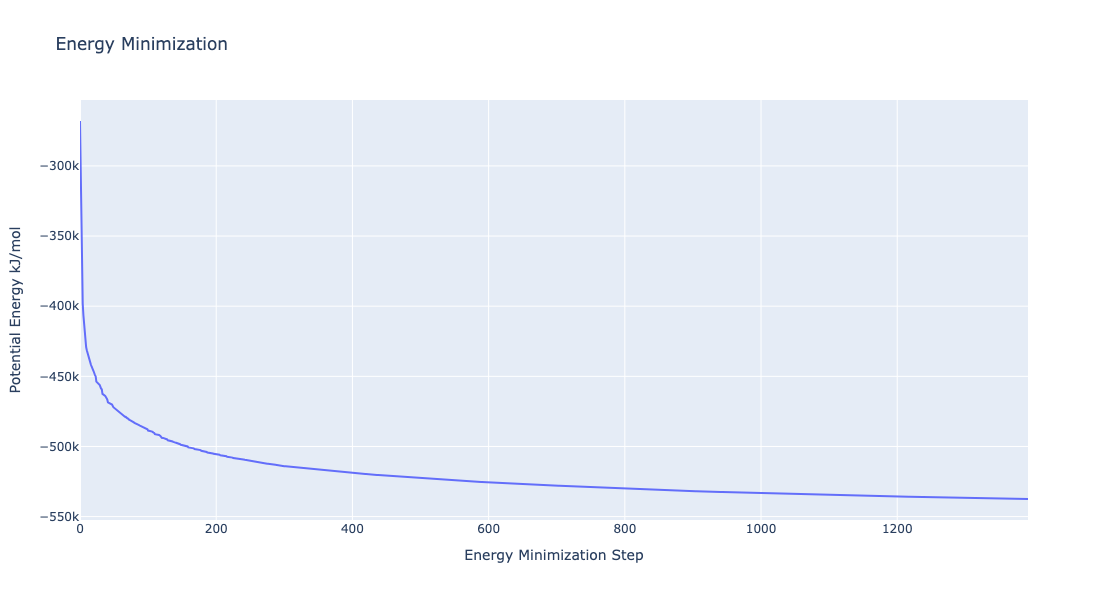

In [27]:
if 'google.colab' in sys.modules: use_colab_plotly()

import plotly.graph_objs as go

#Read data from file and filter energy values higher than 1000 kJ/mol
with open(output_min_ene_xvg, 'r') as energy_file:
    x, y = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in energy_file
        if not line.startswith(("#", "@"))
        if float(line.split()[1]) < 1000
    ])

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines'))

# Update layout
fig.update_layout(title="Energy Minimization",
                  xaxis_title="Energy Minimization Step",
                  yaxis_title="Potential Energy kJ/mol",
                  height=600)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

if 'google.colab' in sys.modules: use_conda_env()

<a id="nvt"></a>
***
## Equilibrate the system (NVT)
Equilibrate the **protein-ligand complex** system in NVT ensemble (constant Number of particles, Volume and Temperature). To avoid temperature coupling problems, a new *"system"* group will be created including the **protein** + the **ligand** to be assigned to a single thermostatting group.

- [Step 1](#eqNVTStep1): Creating an index file with a new group including the **protein-ligand complex**.
- [Step 2](#eqNVTStep3): Creating portable binary run file for system equilibration
- [Step 3](#eqNVTStep3): Equilibrate the **protein-ligand complex** with NVT ensemble.
- [Step 4](#eqNVTStep4): Checking **NVT Equilibration** results. Plotting **system temperature** by time during the **NVT equilibration** process. 
***
**Building Blocks** used:
- [MakeNdx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.make_ndx) from **biobb_gromacs.gromacs.make_ndx** 
- [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_gromacs.gromacs.grompp** 
- [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_gromacs.gromacs.mdrun** 
- [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="eqNVTStep1"></a>
### Step 1: Creating an index file with a new group including the **protein-ligand complex**

In [28]:
# MakeNdx: Creating index file with a new group (protein-ligand complex)
from biobb_gromacs.gromacs.make_ndx import make_ndx

# Create prop dict and inputs/outputs
output_complex_ndx = pdbCode+'_'+ligandCode+'_index.ndx'
prop = {
    'selection': "\"Protein\"|\"Other\"" 
}

# Create and launch bb
make_ndx(input_structure_path=output_min_gro,
        output_ndx_path=output_complex_ndx,
        properties=prop)

2026-01-28 17:19:27,894 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.make_ndx Version: 5.2.0
2026-01-28 17:19:27,897 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_4aedcab0-cfa3-4321-bca5-037df90cd0ac
2026-01-28 17:19:27,898 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_min.gro --> sandbox_4aedcab0-cfa3-4321-bca5-037df90cd0ac
2026-01-28 17:19:27,900 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/828dff1e-a676-4a08-a17f-a026adfa61fa.stdin --> sandbox_4aedcab0-cfa3-4321-bca5-037df90cd0ac
2026-01-28 17:19:27,901 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx -nobackup -nocopyright make_ndx -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sand

2026-01-28 17:19:28,012 [MainThread  ] [INFO ]                 :-) GROMACS - gmx make_ndx, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright make_ndx -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_4aedcab0-cfa3-4321-bca5-037df90cd0ac/3HTB_JZ4_min.gro -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_4aedcab0-cfa3-4321-bca5-037df90cd0ac/3HTB_JZ4_index.ndx


Reading structure file

GROMACS reminds you: "Do the Dog On the Ground" (Red Hot Chili Peppers)




2026-01-28 17:19:28,014 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_4aedcab0-cfa3-4321-bca5-037df90cd0ac', '/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/828dff1e-a676-4a08-a17f-a026adfa61fa.stdin']
2026-01-28 17:19:28,015 [MainThread  ] [INFO ]  


0

<a id="eqNVTStep2"></a>
### Step 2: Creating portable binary run file for system equilibration (NVT)
Note that for the purposes of temperature coupling, the **protein-ligand complex** (*Protein_Other*) is considered as a single entity.

In [29]:
# Grompp: Creating portable binary run file for NVT System Equilibration
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
output_gppnvt_tpr = pdbCode+'_'+ligandCode+'gppnvt.tpr'
prop = {
    'mdp':{
        'nsteps':'5000',
        'tc-grps': 'Protein_Other Water_and_ions',
        'Define': '-DPOSRES -D' + posresifdef
    },
    'simulation_type':'nvt'
}

# Create and launch bb
grompp(input_gro_path=output_min_gro,
       input_top_zip_path=output_genion_top_zip,
       input_ndx_path=output_complex_ndx,
       output_tpr_path=output_gppnvt_tpr,
       properties=prop)

2026-01-28 17:19:29,407 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.grompp Version: 5.2.0
2026-01-28 17:19:29,409 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_ac2d699f-5d80-46a7-a2c5-faf5a6e29c1d
2026-01-28 17:19:29,410 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_min.gro --> sandbox_ac2d699f-5d80-46a7-a2c5-faf5a6e29c1d
2026-01-28 17:19:29,412 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_index.ndx --> sandbox_ac2d699f-5d80-46a7-a2c5-faf5a6e29c1d
2026-01-28 17:19:29,418 [MainThread  ] [INFO ]  Extracting: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_genion_top.zip
2026-01-28 17:19:29,418 [MainThread  ] [INFO ]  to:
2026-01-28 17:19:29,419 [MainThread  ] [INFO ]  ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein

2026-01-28 17:19:29,790 [MainThread  ] [INFO ]                  :-) GROMACS - gmx grompp, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright grompp -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_ac2d699f-5d80-46a7-a2c5-faf5a6e29c1d/grompp.mdp -c /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_ac2d699f-5d80-46a7-a2c5-faf5a6e29c1d/3HTB_JZ4_min.gro -r /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_ac2d699f-5d80-46a7-a2c5-faf5a6e29c1d/3

2026-01-28 17:19:29,793 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_ac2d699f-5d80-46a7-a2c5-faf5a6e29c1d']
2026-01-28 17:19:29,794 [MainThread  ] [INFO ]  


0

<a id="eqNVTStep3"></a>
### Step 3: Running NVT equilibration

In [30]:
# Mdrun: Running NVT System Equilibration 
from biobb_gromacs.gromacs.mdrun import mdrun

# Create prop dict and inputs/outputs
output_nvt_trr = pdbCode+'_'+ligandCode+'_nvt.trr'
output_nvt_gro = pdbCode+'_'+ligandCode+'_nvt.gro'
output_nvt_edr = pdbCode+'_'+ligandCode+'_nvt.edr'
output_nvt_log = pdbCode+'_'+ligandCode+'_nvt.log'
output_nvt_cpt = pdbCode+'_'+ligandCode+'_nvt.cpt'

# Create and launch bb
mdrun(input_tpr_path=output_gppnvt_tpr,
      output_trr_path=output_nvt_trr,
      output_gro_path=output_nvt_gro,
      output_edr_path=output_nvt_edr,
      output_log_path=output_nvt_log,
      output_cpt_path=output_nvt_cpt)

2026-01-28 17:19:31,466 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.mdrun Version: 5.2.0
2026-01-28 17:19:31,468 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_f08bcacd-f340-43e2-a15d-0b458e809c2b
2026-01-28 17:19:31,468 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4gppnvt.tpr --> sandbox_f08bcacd-f340-43e2-a15d-0b458e809c2b
2026-01-28 17:19:31,470 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx -nobackup -nocopyright mdrun -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_f08bcacd-f340-43e2-a15d-0b458e809c2b/3HTB_JZ4_nvt.trr -s /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_f08bcacd-f340-43e2-a15d-0b458e809c2b/3HTB_JZ4gppnvt.tpr -c /Users/gbayarri/projects/BioBB/

2026-01-28 17:20:26,431 [MainThread  ] [INFO ]                  :-) GROMACS - gmx mdrun, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright mdrun -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_f08bcacd-f340-43e2-a15d-0b458e809c2b/3HTB_JZ4_nvt.trr -s /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_f08bcacd-f340-43e2-a15d-0b458e809c2b/3HTB_JZ4gppnvt.tpr -c /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_f08bcacd-f340-43e2-a15d-0b458e80

2026-01-28 17:20:26,437 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_f08bcacd-f340-43e2-a15d-0b458e809c2b', 'traj_comp.xtc']
2026-01-28 17:20:26,438 [MainThread  ] [INFO ]  


0

<a id="eqNVTStep4"></a>
### Step 4: Checking NVT Equilibration results
Checking **NVT Equilibration** results. Plotting **system temperature** by time during the NVT equilibration process. 

In [31]:
# GMXEnergy: Getting system temperature by time during NVT Equilibration  
from biobb_analysis.gromacs.gmx_energy import gmx_energy

# Create prop dict and inputs/outputs
output_nvt_temp_xvg = pdbCode+'_'+ligandCode+'_nvt_temp.xvg'
prop = {
    'terms':  ["Temperature"]
}

# Create and launch bb
gmx_energy(input_energy_path=output_nvt_edr, 
          output_xvg_path=output_nvt_temp_xvg, 
          properties=prop)

2026-01-28 17:20:33,277 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_energy Version: 5.2.0
2026-01-28 17:20:33,281 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_8df05468-7cc1-41c6-b02b-d1366c53782e
2026-01-28 17:20:33,283 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_nvt.edr --> sandbox_8df05468-7cc1-41c6-b02b-d1366c53782e
2026-01-28 17:20:33,286 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx energy -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_8df05468-7cc1-41c6-b02b-d1366c53782e/3HTB_JZ4_nvt.edr -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/noteboo

2026-01-28 17:20:33,337 [MainThread  ] [INFO ]                  :-) GROMACS - gmx energy, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx energy -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_8df05468-7cc1-41c6-b02b-d1366c53782e/3HTB_JZ4_nvt.edr -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_8df05468-7cc1-41c6-b02b-d1366c53782e/3HTB_JZ4_nvt_temp.xvg -xvg none

Opened /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_8df05468-7cc1-41c6-b02b-d1366c53782

2026-01-28 17:20:33,339 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_8df05468-7cc1-41c6-b02b-d1366c53782e']
2026-01-28 17:20:33,340 [MainThread  ] [INFO ]  


0

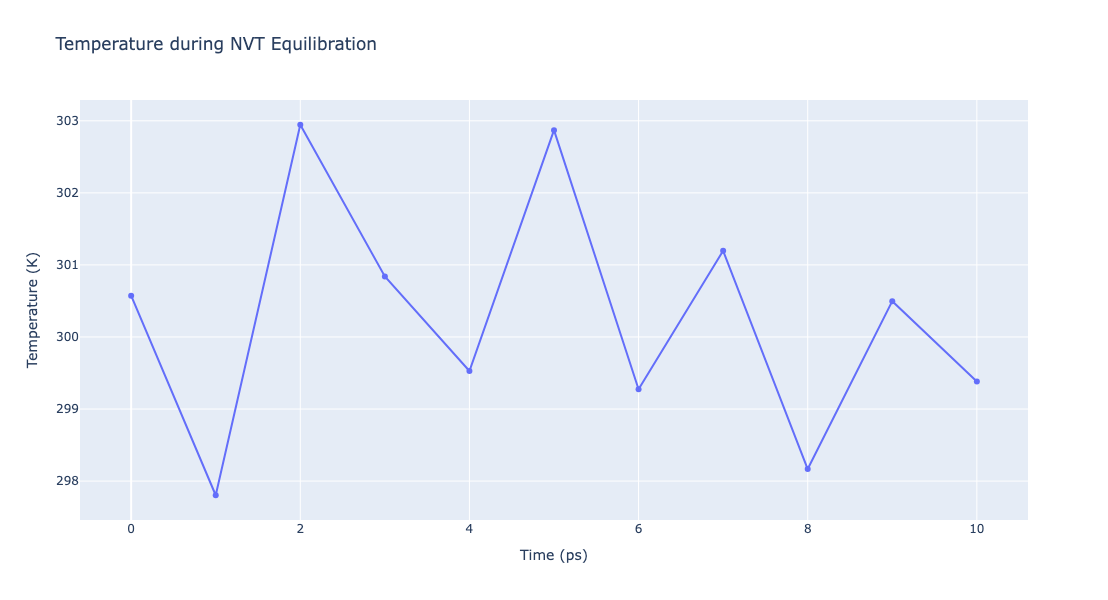

In [32]:
if 'google.colab' in sys.modules: use_colab_plotly()

import plotly.graph_objs as go

# Read temperature data from file 
with open(output_nvt_temp_xvg, 'r') as temperature_file:
    x, y = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in temperature_file
        if not line.startswith(("#", "@"))
    ])

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines+markers'))

# Update layout
fig.update_layout(title="Temperature during NVT Equilibration",
                  xaxis_title="Time (ps)",
                  yaxis_title="Temperature (K)",
                  height=600)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

if 'google.colab' in sys.modules: use_conda_env()

<a id="npt"></a>
***
## Equilibrate the system (NPT)
Equilibrate the **protein-ligand complex** system in NPT ensemble (constant Number of particles, Pressure and Temperature) .
- [Step 1](#eqNPTStep1): Creating portable binary run file for system equilibration
- [Step 2](#eqNPTStep2): Equilibrate the **protein-ligand complex** with NPT ensemble.
- [Step 3](#eqNPTStep3): Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_gromacs.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_gromacs.gromacs.mdrun** 
 - [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="eqNPTStep1"></a>
### Step 1: Creating portable binary run file for system equilibration (NPT)

In [33]:
# Grompp: Creating portable binary run file for (NPT) System Equilibration
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
output_gppnpt_tpr = pdbCode+'_'+ligandCode+'_gppnpt.tpr'
prop = {
    'mdp':{
        'type': 'npt',
        'nsteps':'5000',
        'tc-grps': 'Protein_Other Water_and_ions',
        'Define': '-DPOSRES -D' + posresifdef
    },
    'simulation_type':'npt'
}

# Create and launch bb
grompp(input_gro_path=output_nvt_gro,
       input_top_zip_path=output_genion_top_zip,
       input_ndx_path=output_complex_ndx,
       output_tpr_path=output_gppnpt_tpr,
       input_cpt_path=output_nvt_cpt,
       properties=prop)

2026-01-28 17:20:36,988 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.grompp Version: 5.2.0
2026-01-28 17:20:36,990 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_6a05d02e-2e8f-45ae-94a5-3f08f12ec90c
2026-01-28 17:20:36,991 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_nvt.gro --> sandbox_6a05d02e-2e8f-45ae-94a5-3f08f12ec90c
2026-01-28 17:20:36,994 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_nvt.cpt --> sandbox_6a05d02e-2e8f-45ae-94a5-3f08f12ec90c
2026-01-28 17:20:36,996 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_index.ndx --> sandbox_6a05d02e-2e8f-45ae-94a5-3f08f12ec90c
2026-01-28 17:20:36,999 [MainThread  ] [INFO ]  Extracting: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_genion_top.zip
2026-01-28 17:20:36,999 [MainThread  ] [INFO ]  to:
2026-01-28 1

2026-01-28 17:20:37,398 [MainThread  ] [INFO ]                  :-) GROMACS - gmx grompp, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright grompp -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_6a05d02e-2e8f-45ae-94a5-3f08f12ec90c/grompp.mdp -c /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_6a05d02e-2e8f-45ae-94a5-3f08f12ec90c/3HTB_JZ4_nvt.gro -r /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_6a05d02e-2e8f-45ae-94a5-3f08f12ec90c/3

2026-01-28 17:20:37,400 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_6a05d02e-2e8f-45ae-94a5-3f08f12ec90c']
2026-01-28 17:20:37,401 [MainThread  ] [INFO ]  


0

<a id="eqNPTStep2"></a>
### Step 2: Running NPT equilibration

In [34]:
# Mdrun: Running NPT System Equilibration
from biobb_gromacs.gromacs.mdrun import mdrun

# Create prop dict and inputs/outputs
output_npt_trr = pdbCode+'_'+ligandCode+'_npt.trr'
output_npt_gro = pdbCode+'_'+ligandCode+'_npt.gro'
output_npt_edr = pdbCode+'_'+ligandCode+'_npt.edr'
output_npt_log = pdbCode+'_'+ligandCode+'_npt.log'
output_npt_cpt = pdbCode+'_'+ligandCode+'_npt.cpt'

# Create and launch bb
mdrun(input_tpr_path=output_gppnpt_tpr,
      output_trr_path=output_npt_trr,
      output_gro_path=output_npt_gro,
      output_edr_path=output_npt_edr,
      output_log_path=output_npt_log,
      output_cpt_path=output_npt_cpt)

2026-01-28 17:20:39,397 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.mdrun Version: 5.2.0
2026-01-28 17:20:39,399 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_cc4dd7ee-1e54-4442-bbab-c5a5649c58a4
2026-01-28 17:20:39,400 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_gppnpt.tpr --> sandbox_cc4dd7ee-1e54-4442-bbab-c5a5649c58a4
2026-01-28 17:20:39,402 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx -nobackup -nocopyright mdrun -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_cc4dd7ee-1e54-4442-bbab-c5a5649c58a4/3HTB_JZ4_npt.trr -s /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_cc4dd7ee-1e54-4442-bbab-c5a5649c58a4/3HTB_JZ4_gppnpt.tpr -c /Users/gbayarri/projects/BioB

2026-01-28 17:21:44,625 [MainThread  ] [INFO ]                  :-) GROMACS - gmx mdrun, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright mdrun -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_cc4dd7ee-1e54-4442-bbab-c5a5649c58a4/3HTB_JZ4_npt.trr -s /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_cc4dd7ee-1e54-4442-bbab-c5a5649c58a4/3HTB_JZ4_gppnpt.tpr -c /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_cc4dd7ee-1e54-4442-bbab-c5a5649

2026-01-28 17:21:44,632 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_cc4dd7ee-1e54-4442-bbab-c5a5649c58a4', 'traj_comp.xtc']
2026-01-28 17:21:44,633 [MainThread  ] [INFO ]  


0

<a id="eqNPTStep3"></a>
### Step 3: Checking NPT Equilibration results
Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process. 

In [35]:
# GMXEnergy: Getting system pressure and density by time during NPT Equilibration  
from biobb_analysis.gromacs.gmx_energy import gmx_energy

# Create prop dict and inputs/outputs
output_npt_pd_xvg = pdbCode+'_'+ligandCode+'_npt_PD.xvg'
prop = {
    'terms':  ["Pressure","Density"]
}

# Create and launch bb
gmx_energy(input_energy_path=output_npt_edr, 
          output_xvg_path=output_npt_pd_xvg, 
          properties=prop)

2026-01-28 17:21:53,031 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_energy Version: 5.2.0
2026-01-28 17:21:53,033 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_bc09a978-71b2-4d36-b7c9-506bed93c9c6
2026-01-28 17:21:53,034 [MainThread  ] [INFO ]  Copy to stage: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_npt.edr --> sandbox_bc09a978-71b2-4d36-b7c9-506bed93c9c6
2026-01-28 17:21:53,037 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx energy -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_bc09a978-71b2-4d36-b7c9-506bed93c9c6/3HTB_JZ4_npt.edr -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/noteboo

2026-01-28 17:21:53,085 [MainThread  ] [INFO ]                  :-) GROMACS - gmx energy, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx energy -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_bc09a978-71b2-4d36-b7c9-506bed93c9c6/3HTB_JZ4_npt.edr -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_bc09a978-71b2-4d36-b7c9-506bed93c9c6/3HTB_JZ4_npt_PD.xvg -xvg none

Opened /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_bc09a978-71b2-4d36-b7c9-506bed93c9c6/

2026-01-28 17:21:53,087 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_bc09a978-71b2-4d36-b7c9-506bed93c9c6']
2026-01-28 17:21:53,088 [MainThread  ] [INFO ]  


0

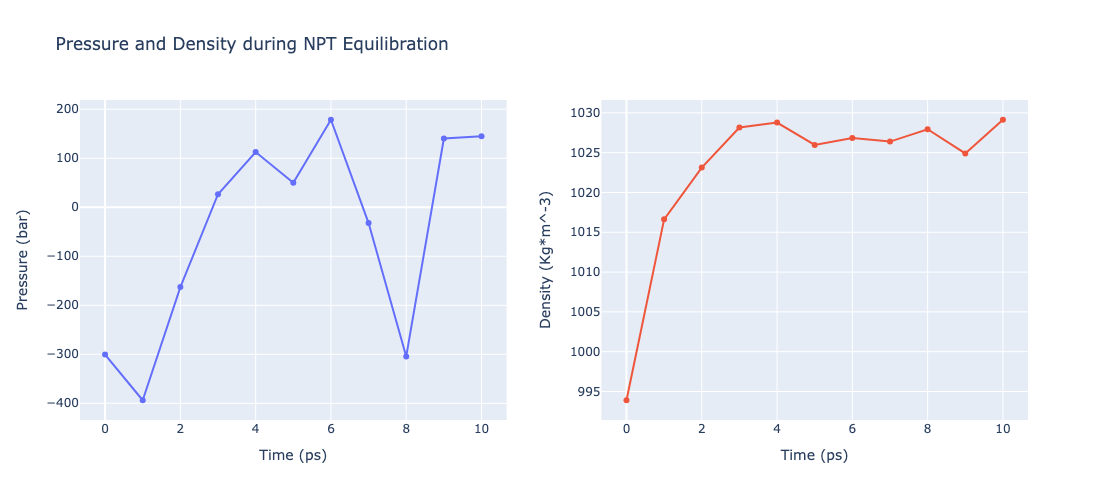

In [36]:
if 'google.colab' in sys.modules: use_colab_plotly()

import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Read pressure and density data from file 
with open(output_npt_pd_xvg,'r') as pd_file:
    x, y, z = zip(*[
        (float(line.split()[0]), float(line.split()[1]), float(line.split()[2]))
        for line in pd_file
        if not line.startswith(("#", "@"))
    ])

trace1 = go.Scatter(
    x=x,y=y
)
trace2 = go.Scatter(
    x=x,y=z
)

fig = make_subplots(rows=1, cols=2, print_grid=False)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig.update_layout(
    height=500,
    title='Pressure and Density during NPT Equilibration',
    showlegend=False,
    xaxis1_title='Time (ps)',
    yaxis1_title='Pressure (bar)',
    xaxis2_title='Time (ps)',
    yaxis2_title='Density (Kg*m^-3)'
)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

if 'google.colab' in sys.modules: use_conda_env()

<a id="free"></a>
***
## Free Molecular Dynamics Simulation
Upon completion of the **two equilibration phases (NVT and NPT)**, the system is now well-equilibrated at the desired temperature and pressure. The **position restraints** can now be released. The last step of the **protein-ligand complex** MD setup is a short, **free MD simulation**, to ensure the robustness of the system. 
- [Step 1](#mdStep1): Creating portable binary run file to run a **free MD simulation**.
- [Step 2](#mdStep2): Run short MD simulation of the **protein-ligand complex**.
- [Step 3](#mdStep3): Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step. 
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_gromacs.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_gromacs.gromacs.mdrun** 
 - [GMXRms](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_rms) from **biobb_analysis.gromacs.gmx_rms** 
 - [GMXRgyr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_rgyr) from **biobb_analysis.gromacs.gmx_rgyr** 
***

<a id="mdStep1"></a>
### Step 1: Creating portable binary run file to run a free MD simulation

In [37]:
# Grompp: Creating portable binary run file for mdrun
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
prop = {
    'mdp':{
        #'nsteps':'500000' # 1 ns (500,000 steps x 2fs per step)
        #'nsteps':'5000' # 10 ps (5,000 steps x 2fs per step)
        'nsteps':'25000' # 50 ps (25,000 steps x 2fs per step)
    },
    'simulation_type':'free'
}
output_gppmd_tpr = pdbCode+'_'+ligandCode + '_gppmd.tpr'

# Create and launch bb
grompp(input_gro_path=output_npt_gro,
       input_top_zip_path=output_genion_top_zip,
       output_tpr_path=output_gppmd_tpr,
       input_cpt_path=output_npt_cpt,
       properties=prop)

2026-01-28 17:21:55,672 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.grompp Version: 5.2.0
2026-01-28 17:21:55,673 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_5299b3d9-2dd4-4e58-b664-9e3f2a491d1c
2026-01-28 17:21:55,675 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_npt.gro --> sandbox_5299b3d9-2dd4-4e58-b664-9e3f2a491d1c
2026-01-28 17:21:55,677 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_npt.cpt --> sandbox_5299b3d9-2dd4-4e58-b664-9e3f2a491d1c
2026-01-28 17:21:55,681 [MainThread  ] [INFO ]  Extracting: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_genion_top.zip
2026-01-28 17:21:55,681 [MainThread  ] [INFO ]  to:
2026-01-28 17:21:55,682 [MainThread  ] [INFO ]  ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-c

2026-01-28 17:21:55,988 [MainThread  ] [INFO ]                  :-) GROMACS - gmx grompp, 2025.4-conda_forge (-:

Executable:   /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup/bin.SSE2/gmx
Data prefix:  /Users/gbayarri/miniconda3/envs/biobb_wf_protein-complex_md_setup
Working dir:  /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright grompp -f /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_5299b3d9-2dd4-4e58-b664-9e3f2a491d1c/grompp.mdp -c /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_5299b3d9-2dd4-4e58-b664-9e3f2a491d1c/3HTB_JZ4_npt.gro -r /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_5299b3d9-2dd4-4e58-b664-9e3f2a491d1c/3

2026-01-28 17:21:55,991 [MainThread  ] [INFO ]  Removed: ['/Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_5299b3d9-2dd4-4e58-b664-9e3f2a491d1c']
2026-01-28 17:21:55,992 [MainThread  ] [INFO ]  


0

<a id="mdStep2"></a>
### Step 2: Running short free MD simulation

In [ ]:
# Mdrun: Running free dynamics
from biobb_gromacs.gromacs.mdrun import mdrun

# Create prop dict and inputs/outputs
output_md_trr = pdbCode+'_'+ligandCode+'_md.trr'
output_md_gro = pdbCode+'_'+ligandCode+'_md.gro'
output_md_edr = pdbCode+'_'+ligandCode+'_md.edr'
output_md_log = pdbCode+'_'+ligandCode+'_md.log'
output_md_cpt = pdbCode+'_'+ligandCode+'_md.cpt'

# Create and launch bb
mdrun(input_tpr_path=output_gppmd_tpr,
      output_trr_path=output_md_trr,
      output_gro_path=output_md_gro,
      output_edr_path=output_md_edr,
      output_log_path=output_md_log,
      output_cpt_path=output_md_cpt)

2026-01-28 17:21:56,988 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.mdrun Version: 5.2.0
2026-01-28 17:21:56,990 [MainThread  ] [INFO ]  Directory successfully created: /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_0d870da1-113b-4484-bf27-2d08959b5bf3
2026-01-28 17:21:56,991 [MainThread  ] [INFO ]  Copy to stage: 3HTB_JZ4_gppmd.tpr --> sandbox_0d870da1-113b-4484-bf27-2d08959b5bf3
2026-01-28 17:21:56,994 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx -nobackup -nocopyright mdrun -o /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_0d870da1-113b-4484-bf27-2d08959b5bf3/3HTB_JZ4_md.trr -s /Users/gbayarri/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/sandbox_0d870da1-113b-4484-bf27-2d08959b5bf3/3HTB_JZ4_gppmd.tpr -c /Users/gbayarri/projects/BioBB/t

<a id="mdStep3"></a>
### Step 3: Checking free MD simulation results
Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step. **RMSd** against the **experimental structure** (input structure of the pipeline) and against the **minimized and equilibrated structure** (output structure of the NPT equilibration step).

In [ ]:
# GMXRms: Computing Root Mean Square deviation to analyse structural stability 
#         RMSd against minimized and equilibrated snapshot (backbone atoms)   

from biobb_analysis.gromacs.gmx_rms import gmx_rms

# Create prop dict and inputs/outputs
output_rms_first = pdbCode+'_'+ligandCode+'_rms_first.xvg'
prop = {
    'selection':  'Backbone'
}

# Create and launch bb
gmx_rms(input_structure_path=output_gppmd_tpr,
         input_traj_path=output_md_trr,
         output_xvg_path=output_rms_first, 
          properties=prop)

In [ ]:
# GMXRms: Computing Root Mean Square deviation to analyse structural stability 
#         RMSd against experimental structure (backbone atoms)   

from biobb_analysis.gromacs.gmx_rms import gmx_rms

# Create prop dict and inputs/outputs
output_rms_exp = pdbCode+'_'+ligandCode+'_rms_exp.xvg'
prop = {
    'selection':  'Backbone'
}

# Create and launch bb
gmx_rms(input_structure_path=output_gppmin_tpr,
         input_traj_path=output_md_trr,
         output_xvg_path=output_rms_exp, 
          properties=prop)

In [ ]:
if 'google.colab' in sys.modules: use_colab_plotly()

import plotly.graph_objs as go

# Read RMS vs first snapshot data from file 
with open(output_rms_first,'r') as rms_first_file:
    x, y = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in rms_first_file
        if not line.startswith(("#", "@"))
    ])

# Read RMS vs experimental structure data from file 
with open(output_rms_exp,'r') as rms_exp_file:
    x2, y2 = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in rms_exp_file
        if not line.startswith(("#", "@"))
    ])

fig = make_subplots()
fig.add_trace(go.Scatter(x=x, y=y, mode="lines+markers", name="RMSd vs first"))
fig.add_trace(go.Scatter(x=x, y=y2, mode="lines+markers", name="RMSd vs exp"))

# Set layout including height
fig.update_layout(
    title="RMSd during free MD Simulation",
    xaxis=dict(title="Time (ps)"),
    yaxis=dict(title="RMSd (nm)"),
    height=600
)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

if 'google.colab' in sys.modules: use_conda_env()

In [ ]:
# GMXRgyr: Computing Radius of Gyration to measure the protein compactness during the free MD simulation 

from biobb_analysis.gromacs.gmx_rgyr import gmx_rgyr

# Create prop dict and inputs/outputs
output_rgyr = pdbCode+'_'+ligandCode+'_rgyr.xvg'
prop = {
    'selection':  'Backbone'
}

# Create and launch bb
gmx_rgyr(input_structure_path=output_gppmin_tpr,
         input_traj_path=output_md_trr,
         output_xvg_path=output_rgyr, 
          properties=prop)

In [ ]:
if 'google.colab' in sys.modules: use_colab_plotly()

import plotly.graph_objs as go

# Read Rgyr data from file
with open(output_rgyr, 'r') as rgyr_file:
    x, y = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in rgyr_file
        if not line.startswith(("#", "@"))
    ])

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines+markers'))

# Update layout
fig.update_layout(title="Radius of Gyration",
                  xaxis_title="Time (ps)",
                  yaxis_title="Rgyr (nm)",
                  height=600)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

if 'google.colab' in sys.modules: use_conda_env()

<a id="post"></a>
***
## Post-processing and Visualizing resulting 3D trajectory
Post-processing and Visualizing the **protein-ligand complex system** MD setup **resulting trajectory** using **NGL**
- [Step 1](#ppStep1): *Imaging* the resulting trajectory, **stripping out water molecules and ions** and **correcting periodicity issues**.
- [Step 2](#ppStep2): Generating a *dry* structure, **removing water molecules and ions** from the final snapshot of the MD setup pipeline.
- [Step 3](#ppStep3): Visualizing the *imaged* trajectory using the *dry* structure as a **topology**. 
***
**Building Blocks** used:
 - [GMXImage](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_image) from **biobb_analysis.gromacs.gmx_image** 
 - [GMXTrjConvStr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_trjconv_str) from **biobb_analysis.gromacs.gmx_trjconv_str** 
***

<a id="ppStep1"></a>
### Step 1: *Imaging* the resulting trajectory.
Stripping out **water molecules and ions** and **correcting periodicity issues**  

In [ ]:
# GMXImage: "Imaging" the resulting trajectory
#           Removing water molecules and ions from the resulting structure
from biobb_analysis.gromacs.gmx_image import gmx_image

# Create prop dict and inputs/outputs
output_imaged_traj = pdbCode+'_imaged_traj.trr'
prop = {
    'center_selection':  'Protein_Other',
    'output_selection': 'Protein_Other',
    'pbc' : 'mol',
    'center' : True
}

# Create and launch bb
gmx_image(input_traj_path=output_md_trr,
         input_top_path=output_gppmd_tpr,
         input_index_path=output_complex_ndx,
         output_traj_path=output_imaged_traj, 
          properties=prop)

<a id="ppStep2"></a>
### Step 2: Generating the output *dry* structure.
**Removing water molecules and ions** from the resulting structure

In [ ]:
# GMXTrjConvStr: Converting and/or manipulating a structure
#                Removing water molecules and ions from the resulting structure
#                The "dry" structure will be used as a topology to visualize 
#                the "imaged dry" trajectory generated in the previous step.
from biobb_analysis.gromacs.gmx_trjconv_str import gmx_trjconv_str

# Create prop dict and inputs/outputs
output_dry_gro = pdbCode+'_md_dry.gro'
prop = {
    'selection':  'Protein_Other'
}

# Create and launch bb
gmx_trjconv_str(input_structure_path=output_md_gro,
                input_top_path=output_gppmd_tpr,
                input_index_path=output_complex_ndx,
                output_str_path=output_dry_gro, 
                properties=prop)

<a id="ppStep3"></a>
### Step 3: Visualizing the generated dehydrated trajectory.
Using the **imaged trajectory** (output of the [Post-processing step 1](#ppStep1)) with the **dry structure** (output of the [Post-processing step 2](#ppStep2)) as a topology.

In [ ]:
# Show trajectory
view = nglview.show_simpletraj(nglview.SimpletrajTrajectory(output_imaged_traj, output_dry_gro), gui=True)
view

<a id="output"></a>
## Output files

Important **Output files** generated:
 - **output_md_gro** (3HTB_JZ4_md.gro): **Final structure** (snapshot) of the MD setup protocol.
 - **output_md_trr** (3HTB_JZ4_md.trr): **Final trajectory** of the MD setup protocol.
 - **output_md_cpt** (3HTB_JZ4_md.cpt): **Final checkpoint file**, with information about the state of the simulation. It can be used to **restart** or **continue** a MD simulation.
 - **output_gppmd_tpr** (3HTB_JZ4_gppmd.tpr): **Final tpr file**, GROMACS portable binary run input file. This file contains the starting structure of the **MD setup free MD simulation step**, together with the molecular topology and all the simulation parameters. It can be used to **extend** the simulation.
 - **output_genion_top_zip** (3HTB_JZ4_genion_top.zip): **Final topology** of the MD system. It is a compressed zip file including a **topology file** (.top) and a set of auxiliary **include topology** files (.itp).

**Analysis** (MD setup check) output files generated:
 - **output_rms_first** (3HTB_JZ4_rms_first.xvg): **Root Mean Square deviation (RMSd)** against **minimized and equilibrated structure** of the final **free MD run step**.
 - **output_rms_exp** (3HTB_JZ4_rms_exp.xvg): **Root Mean Square deviation (RMSd)** against **experimental structure** of the final **free MD run step**.
 - **output_rgyr** (3HTB_JZ4_rgyr.xvg): **Radius of Gyration** of the final **free MD run step** of the **setup pipeline**.
 

***
<a id="questions"></a>

## Questions & Comments

Questions, issues, suggestions and comments are really welcome!

* GitHub issues:
    * [https://github.com/bioexcel/biobb](https://github.com/bioexcel/biobb)

* BioExcel forum:
    * [https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library](https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library)
